# Basic Geographical Symbology

In [1]:
import os
import pandas as pd
import geopandas as gpd
%matplotlib notebook
from shapely.geometry import Point, LineString, Polygon
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

As always lets go ahead import our go to libraries and set some settings.

Today is all about symbology. We are going to _symbolize_ each of the typs discussed in our previous lecture. First lets load in some data so that way we have something to work with. 

In [3]:
os.listdir()

['usa_vote',
 'Corona',
 '.DS_Store',
 'Lab 1 (Intro to Python).ipynb',
 'Lab 6 (Geoprocessing Toolkit 1).ipynb',
 'Lab 4 (Merging Data 1).ipynb',
 '4.2 Walkthrough.ipynb',
 'img',
 'Lab 3 (Descriptive Spatial Statistics).ipynb',
 'Lab 8 (Geoprocessing Toolkit 2).ipynb',
 'Lab 2 (Spatial Objects and Data Types).ipynb',
 '.ipynb_checkpoints',
 'data',
 'common_code.md',
 'Lab 5 (Basic Geographical Symbology).ipynb']

In [4]:
os.chdir('data')

Alright we are going to do something a little more advanced to keep everyone from having to run soooo many execution boxes. Functions! If you remember from early on in the semester we talked about these.  They are essentially a series of commands that you can tell python to do within by defining them not individually, but together. Everything we are doing here is what we did last week so don't get to nervous its just bunched together.

In [5]:
def get_tabular():
    
    food_data = pd.read_csv('food_all.csv', encoding='latin-1')
    
    keep_cols = ['ccode', 'country', 'leader', 'year', 'elected', 'age', 'male',
       'militarycareer', 'government',
       'prev_conflict', 'pt_suc', 'pt_attempt', 'precip', 'couprisk',
       'democracy', 'autocracy', 'day', 'date', 'GEO',
       '_ISO3N_', 'M49 Code_x', 'percap cals']
    
    food_data = food_data[keep_cols]
    
    pts_data = pd.read_csv('PTS-2019.csv', encoding='latin-1')
    
    pts_cols = ['Year', 'COW_Code_N', 'PTS_A', 'PTS_H', 'PTS_S']
    
    pts_data = pts_data[pts_cols]
    
    left_merge = pd.merge(food_data, pts_data, left_on=['year', 'ccode'], right_on=['Year','COW_Code_N'], how='left')
    
    left_merge[left_merge.duplicated(['year', 'ccode'], keep=False)]
    
    left_merge = left_merge.drop_duplicates(subset=['year', 'ccode'], keep='last')
    
    df = left_merge
    
    return df

Now to run our function the way we have set it up, we just call it and set our data frame equal to it.

In [6]:
food_data = get_tabular()

Lets check and make sure!

In [7]:
food_data.head()

,ccode,country,leader,year,elected,age,male,militarycareer,government,prev_conflict,pt_suc,pt_attempt,precip,couprisk,democracy,autocracy,day,date,GEO,_ISO3N_,M49 Code_x,percap cals,Year,COW_Code_N,PTS_A,PTS_H,PTS_S
0,2,USA,Truman,1950,1,66,1,0,Presidential Democracy,0,0,0,-0.022443,NaN,1,0,1,12/1/1950,Northern America,840,840.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,USA,Truman,1951,1,67,1,0,Presidential Democracy,0,0,0,0.360381,NaN,1,0,1,12/1/1951,Northern America,840,840.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,USA,Truman,1952,1,68,1,0,Presidential Democracy,0,0,0,-0.637583,NaN,1,0,1,12/1/1952,Northern America,840,840.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2,USA,Eisenhower,1953,1,63,1,1,Presidential Democracy,0,0,0,-0.437170,NaN,1,0,1,12/1/1953,Northern America,840,840.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2,USA,Eisenhower,1954,1,64,1,1,Presidential Democracy,0,0,0,-0.427828,NaN,1,0,1,12/1/1954,Northern America,840,840.0,NaN,NaN,NaN,NaN,NaN,NaN


Perfect! Now lets do a function to get our world shapefile and narrow it down to the most recent version.

In [8]:
def get_world():
    
    world = gpd.read_file('worldmap/cshapes.shp') 
    
    world = world[world.COWEYEAR == 2016]
    
    return world

In [9]:
world = get_world()

<IPython.core.display.Javascript object>


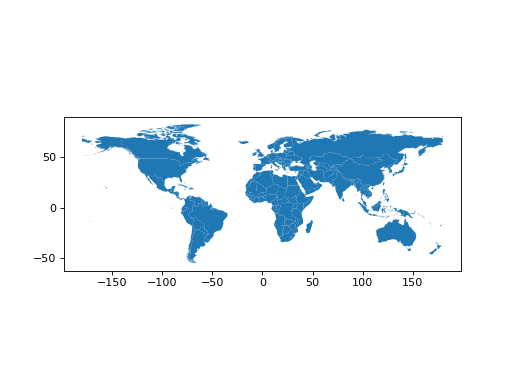

In [10]:
world.plot()

Now lets get a little trickier. Today lets say our question is all about the countries we had worked with in Africa last time namely; Central African Republic, DRC, and Uganda. In addition to all of the country level statstics we want two additional aspects (both which we went over last time).

1. We want a cross-sectional data frame that has those countries with a sum of conflict deaths.
2. An event level file to show each individual event as a point.

In [11]:
def make_two_dfs(food_data, world):
    
    food_data = food_data[food_data.year == 2014] ##snapshot of 2014 for our food, regime, and state charicteristics data
    
    world = world.merge(food_data, left_on='COWCODE', right_on='ccode', how='left')
    
    countrys = ['Uganda', 'Central African Republic', 'Congo, DRC']
    
    central_af = world[world.CNTRY_NAME.isin(countrys)]
    
    # now lets get the two things we want. 
    
    ged_2014 = pd.read_csv('ged_2014.csv')
    
    country_sums = ged_2014.groupby('country_id')['best'].sum().reset_index() ## LEts get the sum of deaths by country
    
    central_af = central_af.merge(country_sums, left_on='COWCODE', right_on='country_id', how='left') ## And here we satisfy our first requirement
    
    codes = [482, 490, 500]
    
    ged_car = ged_2014[ged_2014.country_id.isin(codes)]
    
    ged_geometry = [Point(xy) for xy in zip(ged_car.longitude, ged_car.latitude)] ## Lets make our geometry 
    
    ged_gdf = gpd.GeoDataFrame(ged_car, geometry = ged_geometry) ## Finally lets get number 2
    
    return central_af, ged_gdf

In [12]:
world2, ged_gdf = make_two_dfs(food_data, world)

Lets check and make sure we got what we want.

In [13]:
world2.head()

,CNTRY_NAME,AREA,CAPNAME,CAPLONG,CAPLAT,FEATUREID,COWCODE,COWSYEAR,COWSMONTH,COWSDAY,COWEYEAR,COWEMONTH,COWEDAY,GWCODE,GWSYEAR,GWSMONTH,GWSDAY,GWEYEAR,GWEMONTH,GWEDAY,ISONAME,ISO1NUM,ISO1AL2,ISO1AL3,geometry,ccode,country,leader,year,elected,age,male,militarycareer,government,prev_conflict,pt_suc,pt_attempt,precip,couprisk,democracy,autocracy,day,date,GEO,_ISO3N_,M49 Code_x,percap cals,Year,COW_Code_N,PTS_A,PTS_H,PTS_S,country_id,best
0,Central African Republic,6.226966e+05,Bangui,18.58333,4.366667,70,482,1960,8,13,2016,6,30,482,1960,8,13,2016,6,30,Central African Republic,140,CF,CAF,"POLYGON ((20.45330 4.52379, 20.45798 4.61931, ...",482.0,Cen African Rep,Samba-Panza,2014.0,0.0,58.0,0.0,0.0,Provisional - Civilian,1.0,0.0,0.0,-0.153622,0.002999,0.0,1.0,1.0,12/1/2014,Middle Africa,140.0,140.0,NaN,2014.0,482.0,5.0,5.0,5.0,482,3011
1,"Congo, DRC",2.342043e+06,Kinshasa,15.31500,-4.329722,170,490,1960,6,30,2016,6,30,490,1960,6,30,2016,6,30,"Congo, Democratic Republic of the",180,CD,COD,"POLYGON ((16.10007 -5.85937, 15.92834 -5.86139...",490.0,Congo/Zaire,Joseph Kabila,2014.0,1.0,43.0,1.0,0.0,Personal Dictatorship,0.0,0.0,0.0,-0.067237,0.001102,0.0,1.0,1.0,12/1/2014,Middle Africa,180.0,NaN,NaN,2014.0,490.0,5.0,3.0,5.0,490,1574
2,Uganda,2.437028e+05,Kampala,32.56556,0.315556,59,500,1962,10,9,2016,6,30,500,1962,10,9,2016,6,30,Uganda,800,UG,UGA,"POLYGON ((32.89035 -0.99971, 32.74242 -0.99972...",500.0,Uganda,Museveni,2014.0,1.0,70.0,1.0,0.0,Personal Dictatorship,0.0,0.0,0.0,-0.080365,0.001301,0.0,1.0,1.0,12/1/2014,Eastern Africa,800.0,800.0,NaN,2014.0,500.0,3.0,3.0,3.0,500,7


In [14]:
ged_gdf.tail()

,id,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,dyad_name,side_a_new_id,gwnoa,side_a,side_b_new_id,gwnob,side_b,number_of_sources,source_article,source_office,source_date,source_headline,source_original,where_prec,where_coordinates,adm_1,adm_2,latitude,longitude,priogrid_gid,country,country_id,region,event_clarity,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,low,best,high,geometry
7319,240369,2014,1,3,11706,FPRC - Civilians,12382,FPRC - Civilians,4007,NaN,FPRC,1,NaN,Civilians,1,"""HRW,2017-07-31,KILLING WITHOUT CONSEQUENCE Wa...",HRW,7/31/17,"KILLING WITHOUT CONSEQUENCE War Crimes, Crimes...",HRW,1,Boguia,Ouham province,Batangafo region,7.231821,18.303818,140077,Central African Republic,482,Africa,1,1,12/29/14,12/29/14,0,0,2,0,2,2,2,POINT (18.30382 7.23182)
7320,240427,2014,1,3,11706,FPRC - Civilians,12382,FPRC - Civilians,4007,NaN,FPRC,1,NaN,Civilians,1,"""HRW,2017-07-31,KILLING WITHOUT CONSEQUENCE Wa...",HRW,7/31/17,"KILLING WITHOUT CONSEQUENCE War Crimes, Crimes...",HRW,1,Tounda,Ouham province,Batangafo region,7.255304,18.310310,140077,Central African Republic,482,Africa,1,1,12/29/14,12/29/14,0,0,2,0,2,2,2,POINT (18.31031 7.25530)
7321,240428,2014,1,3,11706,FPRC - Civilians,12382,FPRC - Civilians,4007,NaN,FPRC,1,NaN,Civilians,1,"""HRW,2017-07-31,KILLING WITHOUT CONSEQUENCE Wa...",HRW,7/31/17,"KILLING WITHOUT CONSEQUENCE War Crimes, Crimes...",HRW,3,Batangafo region,Ouham province,Batangafo region,7.451315,18.139552,140077,Central African Republic,482,Africa,1,1,12/29/14,12/29/14,0,0,2,0,2,2,2,POINT (18.13955 7.45131)
7322,240435,2014,1,3,11706,FPRC - Civilians,12382,FPRC - Civilians,4007,NaN,FPRC,1,NaN,Civilians,1,"""HRW,2017-07-31,KILLING WITHOUT CONSEQUENCE Wa...",HRW,7/31/17,"KILLING WITHOUT CONSEQUENCE War Crimes, Crimes...",HRW,1,Gbangto,Ouham province,Batangafo region,7.245198,18.307892,140077,Central African Republic,482,Africa,1,1,12/29/14,12/29/14,0,0,1,0,1,1,1,POINT (18.30789 7.24520)
7328,240360,2014,1,3,13388,UPC (Ali Darass Fulani supporters) - Civilians,14329,UPC (Ali Darass Fulani supporters) - Civilians,5999,NaN,UPC (Ali Darass Fulani supporters),1,NaN,Civilians,1,"""HRW,2017-07-31,KILLING WITHOUT CONSEQUENCE Wa...",HRW,7/31/17,"KILLING WITHOUT CONSEQUENCE War Crimes, Crimes...",HRW,1,Ganwa village,Ouaka province,Kouango region,4.921427,20.217721,136481,Central African Republic,482,Africa,1,2,12/29/14,12/31/14,0,0,9,0,9,9,9,POINT (20.21772 4.92143)


Look at all those functions put to good use!  Now instead of line after line of executing files, we just have a few and everything is a little smoother. We are well on our way to becoming more _Pythonic_ coders!

Now that we have our base data from last time all loaded up, lets get to what we want to do today, symbolizing:
- Points
- Lines
- Polygons

## Points

Lets start with points. First lets do a quick points plots like last time.

<IPython.core.display.Javascript object>


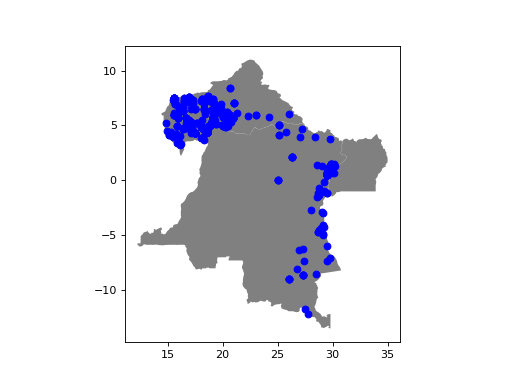

In [15]:
fig, ax = plt.subplots()
world2.plot(ax=ax, facecolor='gray');
ged_gdf.plot(ax=ax, color='blue');
ax.set_aspect('equal')

Now we got all the points plotted onto our map. Great! How about we vary the size some now.

<IPython.core.display.Javascript object>


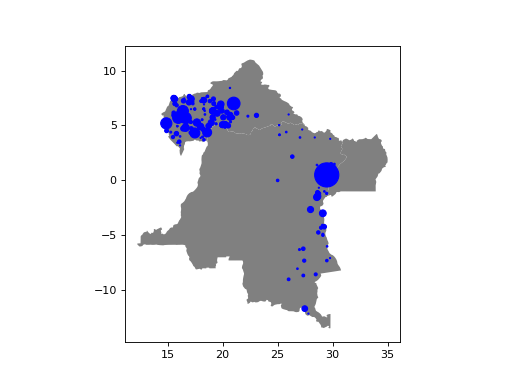

In [16]:
fig, ax = plt.subplots()
world2.plot(ax=ax, facecolor='gray');
ged_gdf.plot(ax=ax, color='blue', markersize=ged_gdf['best']);
ax.set_aspect('equal')

So is this proportional or graduated???

If you guessed __

![correct](https://media.giphy.com/media/PS7d4tm1Hq6Sk/giphy.gif)

Lets do the other one then. First we should check the distribution of the variable.

In [ ]:
ged_gdf.best.describe()

So lets take this continuous variable and chop it up into bins or classes.

In [ ]:
def bin_it(ged_gdf):
    
    bins = [-1, 1.1, 3.1, 8.1, 500]
    labels = [2,5,10,20]
    ged_gdf['best_bin'] = pd.cut(ged_gdf['best'], bins,labels=labels)
    ged_gdf['best_bin'] = ged_gdf['best_bin'].astype(int)
    
    return ged_gdf

In [ ]:
ged_gdf2 = bin_it(ged_gdf)

In [ ]:
fig, ax = plt.subplots()
world2.plot(ax=ax, facecolor='gray');
#scatter = ged_gdf2.plot(ax=ax, color='green', markersize=ged_gdf2['best_bin']);
scatter = ax.scatter(ged_gdf2['longitude'], ged_gdf2['latitude'], color='green', s=ged_gdf2['best_bin'])
ax.set_aspect('equal')

So we now have some proportional and graduated dots on the map.  How about we vary some other aspects of the dots.

### Color

In addition to varying the color, we can also add some other things to our map to make it a little more appealing. Edgecolor, alphas (opacity), and a background color. 

For color lets find a variable that has a few classes that would be important to see the distinction between, how about type of violence.

In [ ]:
fig, ax = plt.subplots()
world2.plot(ax=ax, facecolor='gray', edgecolor='black');
scatter = ax.scatter(ged_gdf2['longitude'], ged_gdf2['latitude'], c=ged_gdf2.type_of_violence, cmap='PiYG', s=ged_gdf2['best_bin'],
                    alpha=0.7)
ax.set_aspect('equal')
ax.set_facecolor('#8C1372')
cbar = fig.colorbar(scatter, ticks=[1, 2, 3])
cbar.ax.set_yticklabels(['State', 'Non-State', 'One-Sided'])


Go ahead and vary some of the colors! Why not choose a new color map. https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

Some color maps will not work well for this one.  Remember your variable types (and what the range is within that variable) is important when thinking about color choices.

Also check out the color wheels and complimentary colors here: https://www.canva.com/colors/color-wheel/

For our next excercise on markers: https://matplotlib.org/1.4.1/api/markers_api.html


### Symbols

In [ ]:
fig, ax = plt.subplots()
world2.plot(ax=ax, facecolor='gray', edgecolor='black');
state = ged_gdf2.loc[ged_gdf2.type_of_violence ==1]
non = ged_gdf2.loc[ged_gdf2.type_of_violence ==2]
one = ged_gdf2.loc[ged_gdf2.type_of_violence ==3]

scatter1 = ax.scatter(state['longitude'], state['latitude'], color='blue', marker='x', s=ged_gdf2['best'],
                    alpha=0.7)
scatter2 = ax.scatter(non['longitude'], non['latitude'], color='green', marker='v', s=ged_gdf2['best'],
                    alpha=0.7)
scatter3 = ax.scatter(one['longitude'], one['latitude'], color='yellow', marker='d', s=ged_gdf2['best'],
                    alpha=0.7)
ax.set_aspect('equal')
ax.set_facecolor('steelblue')

Lets try again with some colors that are actually appealing.  Use the color wheel to pick your own colors!

In [ ]:
fig, ax = plt.subplots()
world2.plot(ax=ax, facecolor='gray', edgecolor='black');
state = ged_gdf2.loc[ged_gdf2.type_of_violence ==1]
non = ged_gdf2.loc[ged_gdf2.type_of_violence ==2]
one = ged_gdf2.loc[ged_gdf2.type_of_violence ==3]

scatter1 = ax.scatter(state['longitude'], state['latitude'], color='#25DAC3', marker='x', s=ged_gdf2['best'],
                    alpha=0.7)
scatter2 = ax.scatter(non['longitude'], non['latitude'], color='#C325DA', marker='v', s=ged_gdf2['best'],
                    alpha=0.7)
scatter3 = ax.scatter(one['longitude'], one['latitude'], color='#DAC325', marker='d', s=ged_gdf2['best'],
                    alpha=0.7)
ax.set_aspect('equal')
ax.set_facecolor('steelblue')

![alright](https://media.giphy.com/media/g5zvwUa9720pO/giphy.gif)

We are making progress!!

Lets move on to changing some lines now.

## Lines

First we can load in some data on rivers.

In [ ]:
rivers = gpd.read_file('central_africa/rivers.shp') 

In [ ]:
rivers.plot(linewidth=rivers.StrokeWeig)

In [ ]:
rivers.head()

Luckily we have something built into this data that gives us a clean value for the river sizes.  Let's add this to our last plot!

In [ ]:
fig, ax = plt.subplots()
world2.plot(ax=ax, facecolor='gray', edgecolor='black');
state = ged_gdf2.loc[ged_gdf2.type_of_violence ==1]
non = ged_gdf2.loc[ged_gdf2.type_of_violence ==2]
one = ged_gdf2.loc[ged_gdf2.type_of_violence ==3]

scatter1 = ax.scatter(state['longitude'], state['latitude'], color='#25DAC3', marker='x', s=ged_gdf2['best'],
                    alpha=0.7)
scatter2 = ax.scatter(non['longitude'], non['latitude'], color='#C325DA', marker='v', s=ged_gdf2['best'],
                    alpha=0.7)
scatter3 = ax.scatter(one['longitude'], one['latitude'], color='#DAC325', marker='d', s=ged_gdf2['best'],
                    alpha=0.7)
rivers.plot(ax=ax, linewidth=rivers.StrokeWeig)
ax.set_aspect('equal')
ax.set_facecolor('steelblue')

Sweet! Lines can be used just like points. You can vary shape, color and size. Lets do one more with the shape. 

In [ ]:
fig, ax = plt.subplots()
world2.plot(ax=ax, facecolor='gray', edgecolor='black');
state = ged_gdf2.loc[ged_gdf2.type_of_violence ==1]
non = ged_gdf2.loc[ged_gdf2.type_of_violence ==2]
one = ged_gdf2.loc[ged_gdf2.type_of_violence ==3]

scatter1 = ax.scatter(state['longitude'], state['latitude'], color='#25DAC3', marker='x', s=ged_gdf2['best'],
                    alpha=0.7)
scatter2 = ax.scatter(non['longitude'], non['latitude'], color='#C325DA', marker='v', s=ged_gdf2['best'],
                    alpha=0.7)
scatter3 = ax.scatter(one['longitude'], one['latitude'], color='#DAC325', marker='d', s=ged_gdf2['best'],
                    alpha=0.7)

rivers.plot(ax=ax, linewidth=rivers.StrokeWeig, linestyle='-.')
ax.set_aspect('equal')
ax.set_facecolor('steelblue')

Zoom in to the map and check it out. You can see that the rivers are actually patterned differently than just a solid line. https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html


On to the main event, Polygons!

## Polygons

Let's go ahead and turn to choropleth maps now.  Very basically you can vary the color within a cross-section of polygons based on some variable. So what would be a good variable in this data to vary. How about we try a few and use different cmaps.

In [ ]:
world2.head()
#world2.precip.describe()

In [ ]:
fig, ax = plt.subplots()
world2.plot(ax=ax, column='precip', cmap='PiYG',facecolor='gray', edgecolor='black', legend=True);
ax.set_aspect('equal')
ax.set_facecolor('steelblue')
plt.title("Precipitation Levels")


Hmmm that one isn't all that pleasing. 

![alright](https://media.giphy.com/media/FYCxLHCIGaioo/giphy.gif)


How about we try one that is sequential.

In [ ]:
fig, ax = plt.subplots()
world2.plot(ax=ax, column='precip', cmap='Wistia',facecolor='gray', edgecolor='black', legend=True);
ax.set_aspect('equal')
ax.set_facecolor('steelblue')
plt.title("Precipitation Levels")


Its better but maybe we want to flip it. Something you can do is reverse a color scheme but just using the simple _r

In [ ]:
fig, ax = plt.subplots()
world2.plot(ax=ax, column='precip', cmap='Wistia_r',facecolor='gray', edgecolor='black', legend=True);
ax.set_aspect('equal')
ax.set_facecolor('steelblue')
plt.title("Precipitation Levels")


Exercise: Why don't you all try and make some other choropleth maps.  Use additional columns, colors, and even add some of the points and lines we have done so far!

# BONUS 

Try to load up the ACLED data.  Then narrow down to only protests and riots and plot that.

In [17]:
!pip install geopandas